In [1]:
import os 

os.chdir("/home/hamza-arain/Documents/code/recmmendation")

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from matplotlib.ticker import PercentFormatter
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from itertools import combinations
from datetime import datetime
import statsmodels.api as sm
import warnings
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet
from sklearn.metrics import r2_score, mean_squared_error

pd.options.mode.chained_assignment = None

plt.rcParams["axes.facecolor"] = "#A2A2A2"
plt.rcParams["axes.grid"] = 1

/home/hamza-arain/Documents/code/recmmendation/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [3]:
# df = pd.read_csv("data/online_retail_final.csv")
# df = pd.read_excel('data/Online Retail.xlsx')
df = pd.read_csv("data/data.csv", encoding="ISO-8859-1")
display(df.head())
print(df.shape)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


(541909, 8)


In [4]:
print("We have {} observations.".format(df.shape[0]))

df = df[df.CustomerID.notnull()]

print("We have {} observations after removing unknown customers.".format(df.shape[0]))

We have 541909 observations.
We have 406829 observations after removing unknown customers.


In [5]:
print("We have {} observations.".format(df.shape[0]))

df = df[df.UnitPrice > 0]

print("We have {} observations after removing records that have 0 unit price.".format(df.shape[0]))

We have 406829 observations.
We have 406789 observations after removing records that have 0 unit price.


/tmp/ipykernel_20636/1658731281.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y = customer_counts.index, x = customer_counts.values, orient = "h",


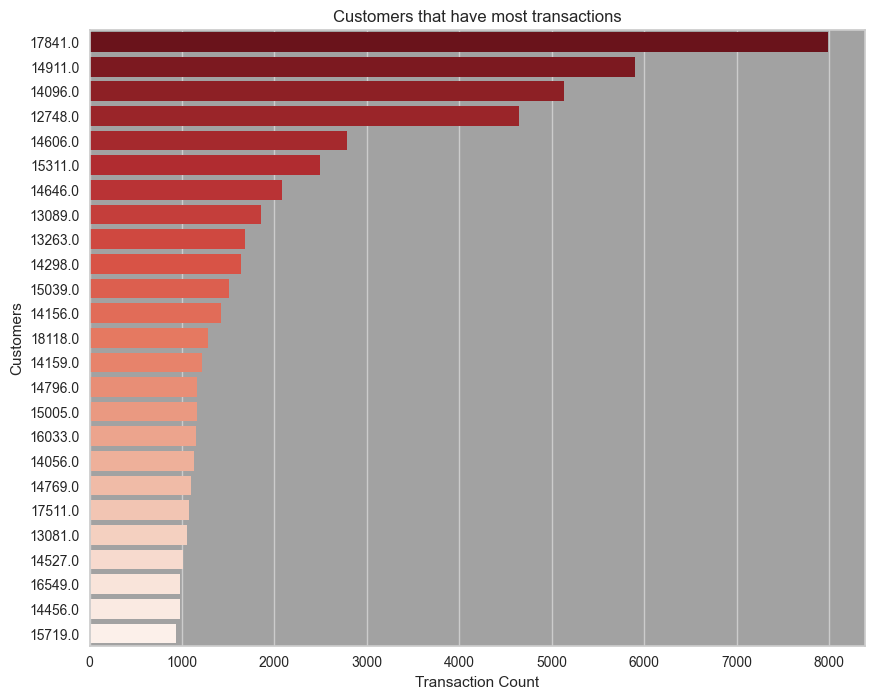

In [6]:
customer_counts = df.CustomerID.value_counts().sort_values(ascending=False).head(25)

fig, ax = plt.subplots(figsize = (10, 8))

sns.barplot(y = customer_counts.index, x = customer_counts.values, orient = "h", 
            ax = ax, order = customer_counts.index, palette = "Reds_r")

plt.title("Customers that have most transactions")
plt.ylabel("Customers")
plt.xlabel("Transaction Count")

plt.show()

/tmp/ipykernel_20636/469778379.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = country_counts.values, y = country_counts.index, orient = "h",


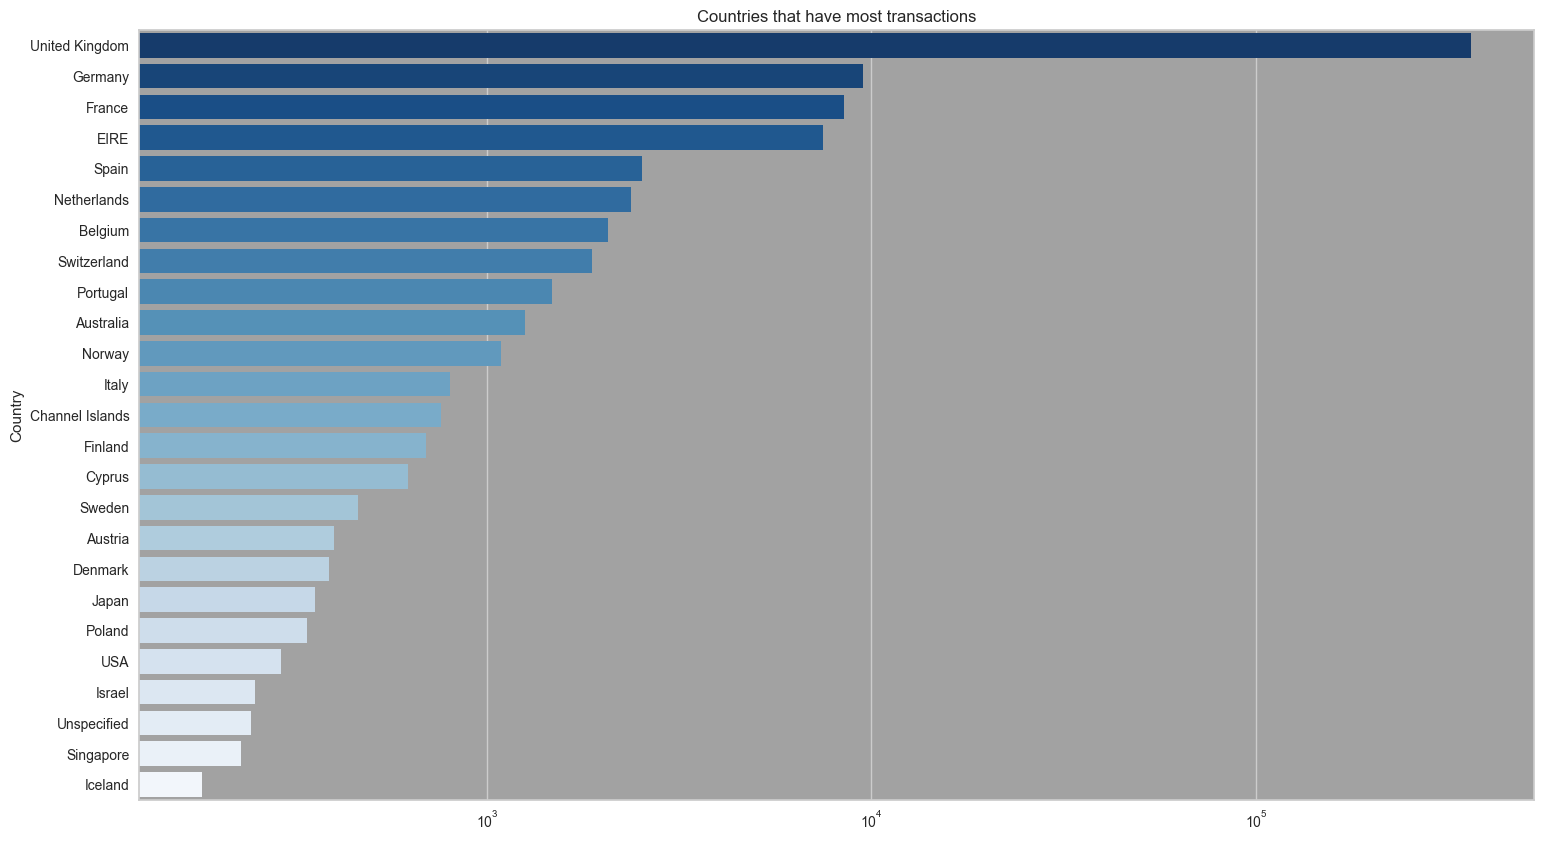

In [7]:
country_counts = df.Country.value_counts().sort_values(ascending=False).head(25)

fig, ax = plt.subplots(figsize = (18, 10))

sns.barplot(x = country_counts.values, y = country_counts.index, orient = "h", 
            ax = ax, order = country_counts.index, palette = "Blues_r")
plt.title("Countries that have most transactions")
plt.xscale("log")
plt.show()

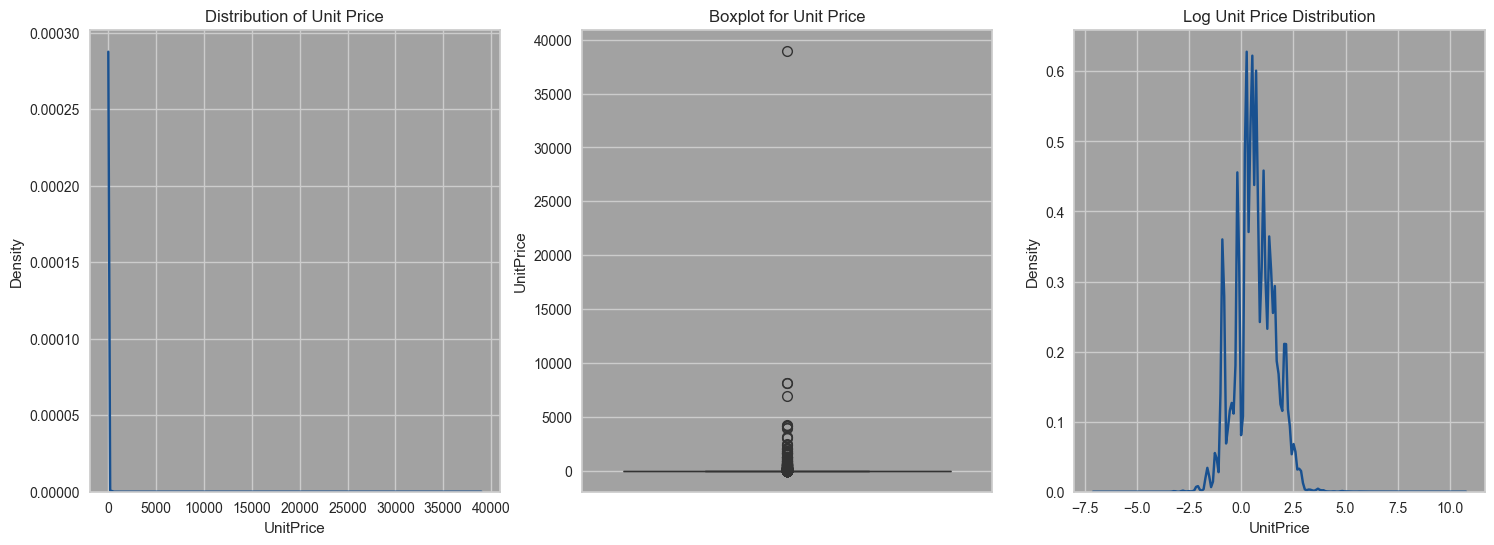

In [8]:
fig, axes = plt.subplots(1, 3, figsize = (18, 6))

sns.kdeplot(df["UnitPrice"], ax = axes[0], color = "#195190").set_title("Distribution of Unit Price")
sns.boxplot(y = df["UnitPrice"], ax = axes[1], color = "#195190").set_title("Boxplot for Unit Price")
sns.kdeplot(np.log(df["UnitPrice"]), ax = axes[2], color = "#195190").set_title("Log Unit Price Distribution")

plt.show()

In [9]:
np.quantile(df.UnitPrice, 0.99)

np.float64(15.0)

For example, the 99th percentile (0.99) means that 99% of the values in df.UnitPrice are less than or equal to this calculated value, while 1% of the values are greater than this value.

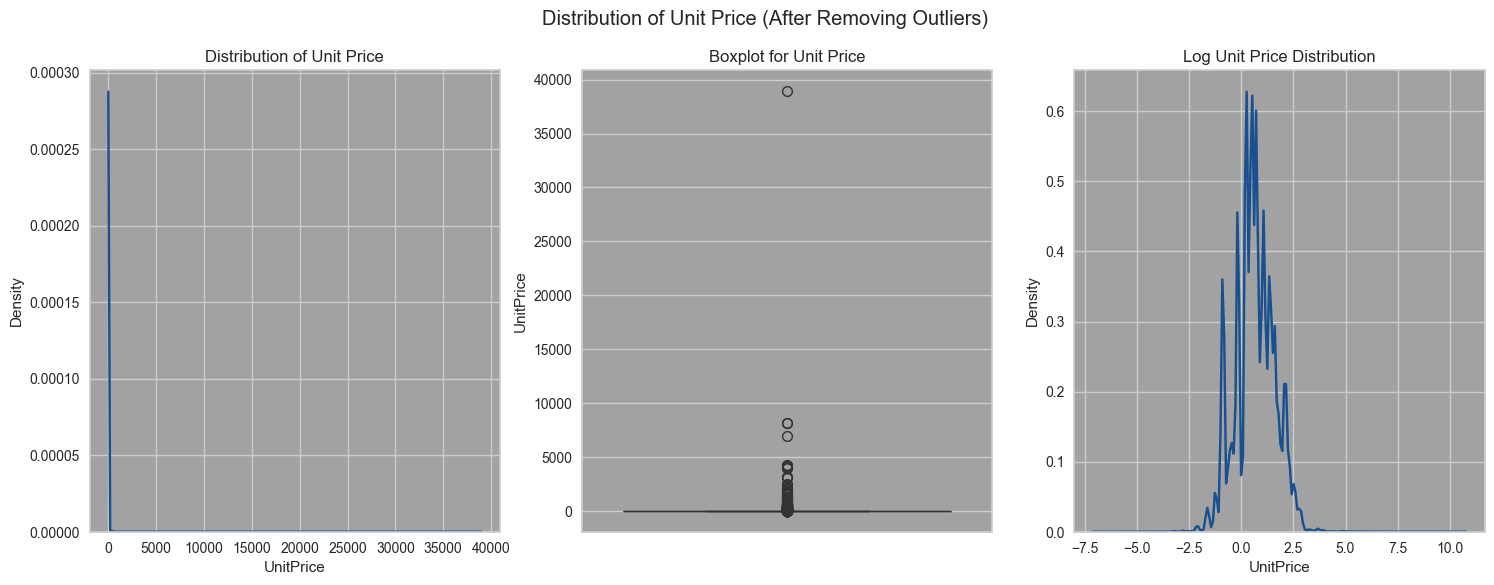

In [10]:
fig, axes = plt.subplots(1, 3, figsize = (18, 6))

sns.kdeplot(df["UnitPrice"], ax = axes[0], color = "#195190").set_title("Distribution of Unit Price")
sns.boxplot(y = df["UnitPrice"], ax = axes[1], color = "#195190").set_title("Boxplot for Unit Price")
sns.kdeplot(np.log(df["UnitPrice"]), ax = axes[2], color = "#195190").set_title("Log Unit Price Distribution")

fig.suptitle("Distribution of Unit Price (After Removing Outliers)")
plt.show()

In [11]:
df["Quantity"].describe()

count    406789.000000
mean         12.028359
std         247.927842
min      -80995.000000
25%           2.000000
50%           5.000000
75%          12.000000
max       80995.000000
Name: Quantity, dtype: float64

/home/hamza-arain/Documents/code/recmmendation/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


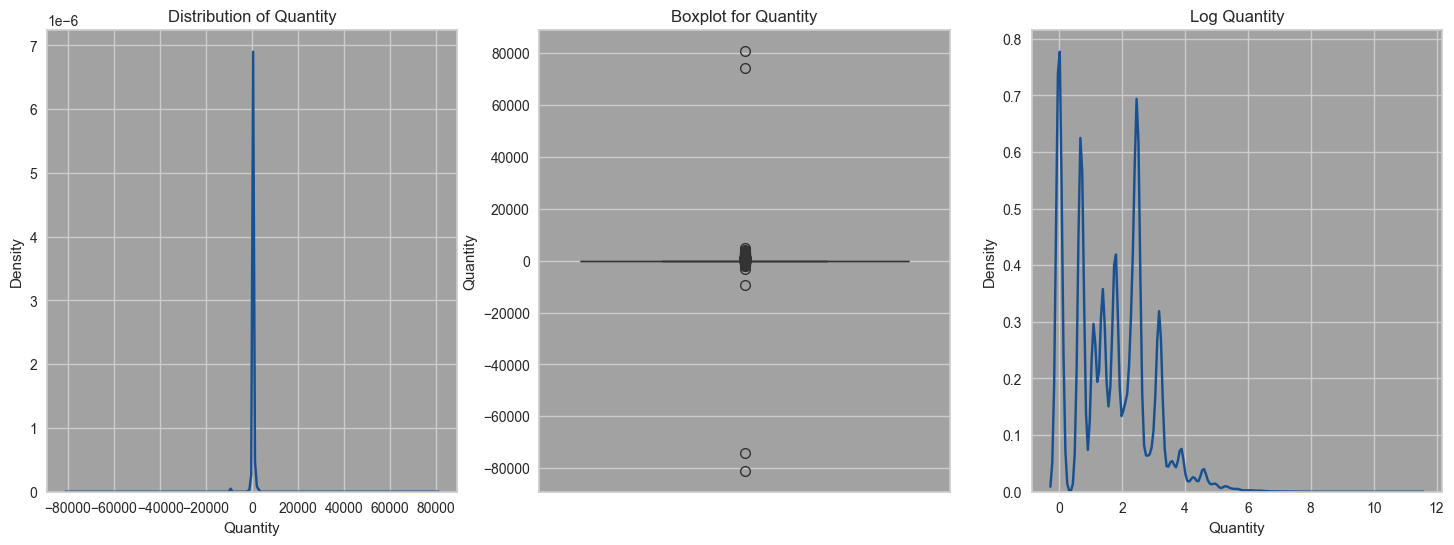

In [12]:
fig, axes = plt.subplots(1, 3, figsize = (18, 6))

sns.kdeplot(df["Quantity"], ax = axes[0], color = "#195190").set_title("Distribution of Quantity")
sns.boxplot(y = df["Quantity"], ax = axes[1], color = "#195190").set_title("Boxplot for Quantity")
sns.kdeplot(np.log(df["Quantity"]), ax = axes[2], color = "#195190").set_title("Log Quantity")
plt.show()

In [13]:
np.quantile(df.Quantity, 0.99)

np.float64(120.0)

In [14]:
print("We have {} observations.".format(df.shape[0]))

df = df[(df.Quantity < 150)]

print("We have {} observations after removing quantities greater than 150.".format(df.shape[0]))

We have 406789 observations.
We have 404090 observations after removing quantities greater than 150.


/home/hamza-arain/Documents/code/recmmendation/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


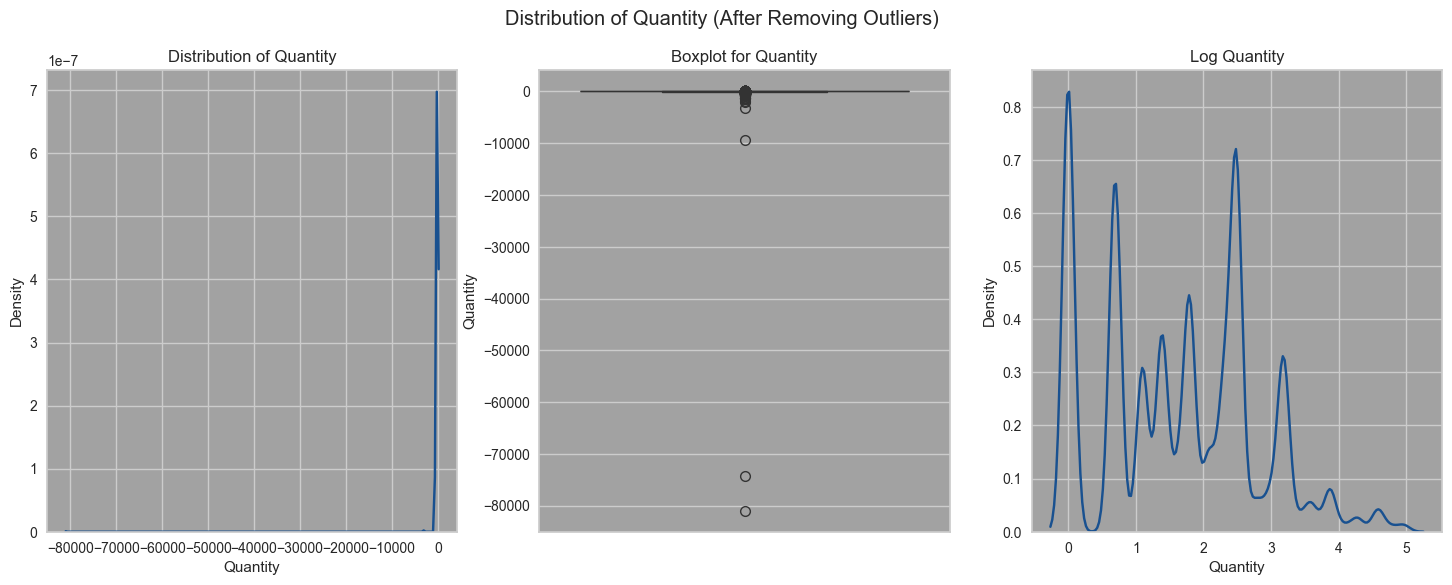

In [15]:
fig, axes = plt.subplots(1, 3, figsize = (18, 6))

sns.kdeplot(df["Quantity"], ax = axes[0], color = "#195190").set_title("Distribution of Quantity")
sns.boxplot(y = df["Quantity"], ax = axes[1], color = "#195190").set_title("Boxplot for Quantity")
sns.kdeplot(np.log(df["Quantity"]), ax = axes[2], color = "#195190").set_title("Log Quantity")

fig.suptitle("Distribution of Quantity (After Removing Outliers)")
plt.show()

In [16]:
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [17]:
# df.drop("Cancelled", axis = 1, inplace = True)
df.to_csv("data/online_retail_final.csv", index = False)